# Imports

In [337]:
import time

import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import torch
from torch import nn
import torch.optim as opt
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader

import utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
torch.__version__

'1.0.0'

# Load Data

In [289]:
PATH = Path('data/processed/')

In [290]:
%ls {PATH}

feature-matrix-stage1  feature-matrix-stage2  labels-dummies


In [291]:
X = feather.read_dataframe(PATH / 'feature-matrix-stage2').set_index('index')
X.index.name = ''
y = feather.read_dataframe(PATH / 'labels-dummies').set_index('index')
X.index.name = ''
X.head()

,FTE,Total,text
,,,
134338,1.0,50471.810,General Fund Teacher-Elementary KINDERGAR...
206341,NaN,3477.860,RGN GOB (blank) CONTRACTOR SERVICES UNDESI...
326408,1.0,62237.130,General Purpose School TCHER 2ND GRADE Pers...
364634,NaN,22.300,"UNALLOC BUDGETS/SCHOOLS Teacher, Short Term ..."
47683,NaN,54.166,"NON-PROJECT Teacher, Secondary (High) TEAC..."


In [292]:
y.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
index,,,,,,,,,,,,,,,,,,,,,
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [293]:
# Name of original features
FEATURES = [
    'FTE', 'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4', 'Total'
]

NUMERICAL_FEATURES = [
    'FTE', 'Total'
]

TEXT_FEATURES = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4',
]
LABELS = [
    'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
    'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
]

In [295]:
(X.index == y.index).all()

True

# Tokenize Text Data

In [296]:
def tokenize(text):
    pattern = re.compile('[a-zA-Z0-9]+')
    return ' '.join(pattern.findall(text.lower()))

In [297]:
X['tokenized_text'] = X['text'].apply(tokenize)
X.tokenized_text.head()


134338    general fund teacher elementary kindergarten k...
206341    rgn gob blank contractor services undesignated...
326408    general purpose school tcher 2nd grade persona...
364634    unalloc budgets schools teacher short term sub...
47683     non project teacher secondary high teacher cov...
Name: tokenized_text, dtype: object

In [298]:
vocab = sorted(list(set(' '.join(X.tokenized_text.values.ravel()).split())))
len(vocab)

3757

In [299]:
words_to_idx = {word:idx for idx, word in enumerate(vocab, 1)}
idx_to_words = {idx:word for word, idx in words_to_idx.items()}
words_to_idx

{'00a': 1,
 '12': 2,
 '1st': 3,
 '2nd': 4,
 '3rd': 5,
 '4': 6,
 '4th': 7,
 '5': 8,
 '56': 9,
 '5th': 10,
 '6': 11,
 '60': 12,
 '60hrs': 13,
 '6th': 14,
 '7': 15,
 '70': 16,
 '70h': 17,
 '70hr': 18,
 '70hrs': 19,
 '70hs': 20,
 '720': 21,
 '8': 22,
 '80': 23,
 '80hrs': 24,
 '80hs': 25,
 '84': 26,
 '9': 27,
 '9th': 28,
 'a': 29,
 'aaps': 30,
 'ab': 31,
 'aba': 32,
 'abatement': 33,
 'absence': 34,
 'absorber': 35,
 'ac': 36,
 'acad': 37,
 'academ': 38,
 'academic': 39,
 'academically': 40,
 'academies': 41,
 'academy': 42,
 'acadmey': 43,
 'acc': 44,
 'accelerated': 45,
 'access': 46,
 'accessories': 47,
 'accident': 48,
 'accnts': 49,
 'accompanists': 50,
 'accoun': 51,
 'account': 52,
 'accountability': 53,
 'accountant': 54,
 'accountants': 55,
 'accounting': 56,
 'accounts': 57,
 'acct': 58,
 'acctblty': 59,
 'achiev': 60,
 'achieve': 61,
 'achievment': 62,
 'achv': 63,
 'acq': 64,
 'acqu': 65,
 'acquis': 66,
 'acquisition': 67,
 'acquisitions': 68,
 'act': 69,
 'acte': 70,
 'acti': 7

In [300]:
def text_to_ints(text):
    text_ints = [words_to_idx[word] for word in text.split()]
    return text_ints

In [301]:
X['text_ints'] = X.tokenized_text.apply(text_to_ints)
X.text_ints[:3]


134338                 [1479, 1439, 3406, 1156, 1975, 1975]
206341    [2952, 1505, 409, 791, 3094, 3576, 469, 1689, ...
326408    [1479, 2784, 3038, 3398, 4, 1514, 2568, 3094, ...
Name: text_ints, dtype: object

In [303]:
len([len(text) for text in X['tokenized_text'] if len(text) == 0])

1874

In [304]:
len([len(text) for text in X['text'] if len(text) == 0])

0

Looks like we have 1,874 rows with no text after tokenization. 

In [305]:
X[X.tokenized_text == ''].shape[0]

1874

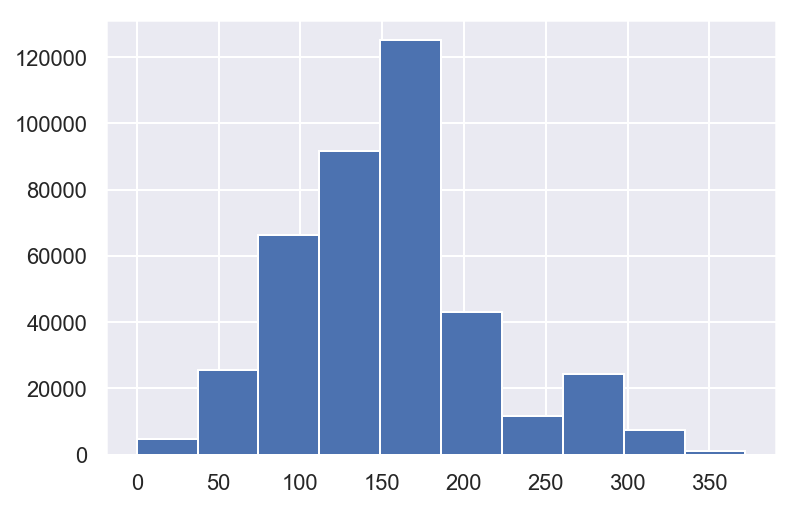

In [306]:
text_lengths = [len(text) for text in X['tokenized_text']]
plt.hist(text_lengths);

In [308]:
# Remove rows that have no words left after tokenization
X_proc = X[X.tokenized_text != '']
y_proc = y[X.tokenized_text != '']

In [302]:
def pad_sequences(seq, max_length):
    '''Implement left-padding.'''
    padded_sequences = np.zeros((len(seq), max_length), dtype=int)
    for i, text in enumerate(seq):
        if len(text) > 0:
            padded_sequences[i, -len(text):] = np.array(text)[:max_length]
    return padded_sequences

In [309]:
padded_text = pad_sequences(X_proc.text_ints.values.tolist(), 200)

In [310]:
padded_text

array([[   0,    0,    0, ..., 1156, 1975, 1975],
       [   0,    0,    0, ...,  427, 1284, 2858],
       [   0,    0,    0, ..., 2858, 2858, 1768],
       ...,
       [   0,    0,    0, ..., 3482, 1656, 2256],
       [   0,    0,    0, ..., 1129, 2921, 3094],
       [   0,    0,    0, ..., 1047, 2714,  987]])

In [311]:
padded_text[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [312]:
X.text_ints[:1]


134338    [1479, 1439, 3406, 1156, 1975, 1975]
Name: text_ints, dtype: object

In [313]:
X_proc.head()

,FTE,Total,text,tokenized_text,text_ints
,,,,,
134338,1.0,50471.810,General Fund Teacher-Elementary KINDERGAR...,general fund teacher elementary kindergarten k...,"[1479, 1439, 3406, 1156, 1975, 1975]"
206341,NaN,3477.860,RGN GOB (blank) CONTRACTOR SERVICES UNDESI...,rgn gob blank contractor services undesignated...,"[2952, 1505, 409, 791, 3094, 3576, 469, 1689, ..."
326408,1.0,62237.130,General Purpose School TCHER 2ND GRADE Pers...,general purpose school tcher 2nd grade persona...,"[1479, 2784, 3038, 3398, 4, 1514, 2568, 3094, ..."
364634,NaN,22.300,"UNALLOC BUDGETS/SCHOOLS Teacher, Short Term ...",unalloc budgets schools teacher short term sub...,"[3572, 467, 3041, 3406, 3130, 3439, 3288, 1170..."
47683,NaN,54.166,"NON-PROJECT Teacher, Secondary (High) TEAC...",non project teacher secondary high teacher cov...,"[2352, 2736, 3406, 3066, 1602, 3406, 857, 1396..."


# Sample Data

We will be using 10% of the data to faster iterations between models. Then 80% of those data will be for training and 20% for validation. Once we are happy with the model, we can refit it with the full training data from first step and do the submissions

In [329]:
batch_size = 64

In [343]:
# Will be using all data here
idxs = np.random.permutation(range(len(padded_text)))
train_idxs = idxs[:int((1 - 0.8) * len(idxs))]
valid_idxs = idxs[int((1 - 0.8) * len(idxs)):]

# Samplers
train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(valid_idxs)

# Dataset
ds = TensorDataset(torch.from_numpy(padded_text), torch.from_numpy(y_proc.values))

# Dataloaders
train_dl = DataLoader(ds, batch_size, sampler=train_sampler)
valid_dl = DataLoader(ds, batch_size, sampler=valid_sampler) 

In [344]:
sample_x, sample_y = next(iter(train_dl))
sample_x.shape, sample_y.shape

(torch.Size([64, 200]), torch.Size([64, 104]))

# Model

## Embedding

In [314]:
def load_embeddings(fname):
    '''Load Embeddings matrix from `fname`.'''
    embeddings_index = {}
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            data = line.split()
            word = data[0]
            values = np.array(data[1:]).astype(float)
            embeddings_index[word] = values
    
    return embeddings_index

In [315]:
embeddings_index = load_embeddings('/Users/imad/Downloads/glove/glove.6B.300d.txt')

In [316]:
def create_embeddings_matrix(embeddings_index, vocab_to_idx):
    '''
    Create Embeddings matrix from Embeddings index given a vocab dictionary.
    '''
    vocab_size = len(vocab_to_idx) + 1
    embeddings_dim = len(list(embeddings_index.values())[0])
    embeddings_matrix = np.zeros((vocab_size, embeddings_dim))
    n_found_words = 0

    for word, i in vocab_to_idx.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i - 1] = embeddings_vector
            n_found_words += 1
    
    return embeddings_matrix, n_found_words

In [317]:
embeddings_matrix, n_found_words = create_embeddings_matrix(embeddings_index, words_to_idx)

In [318]:
print(f'Vocab size  : {vocab_size}\n'
      f'Found words : {n_found_words}')

Vocab size  : 3758
Found words : 3031


In [319]:
def create_embed_layer(
    num_embeddings, embedding_dim, embeddings_matrix, trainable=False):
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(embeddings_matrix)})
    
    if not trainable:
        emb_layer.weight.requires_grad = False
    
    return emb_layer

In [320]:
class RNN(nn.Module):
    
    def __init__(self, input_size, embedding_dim, embeddings_matrix, hidden_size,
                 output_size, n_layers, drop_out=0.5):
        super().__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_out = drop_out

        self.embed = create_embed_layer(self.input_size, self.embedding_dim,
                                        embeddings_matrix)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, self.n_layers,
                       batch_first=True, dropout=drop_out)
        self.drop = nn.Dropout(drop_out)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        out = self.embed(x)
        out, hidden = self.lstm(out, hidden)
        out = self.drop(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        out = out.view(batch_size, self.output_size, -1)[:, :, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))
        
        return hidden

## LSTM

In [345]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [346]:
embedding_dim = 300
hidden_size = 100
output_size = y.shape[1]
n_layers = 2

In [347]:
net = RNN(vocab_size, embedding_dim, embeddings_matrix, hidden_size, output_size, n_layers)
net

RNN(
  (embed): Embedding(3758, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.5)
  (drop): Dropout(p=0.5)
  (fc): Linear(in_features=100, out_features=104, bias=True)
)

In [348]:
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = opt.Adam(net.parameters(), lr=1e-3)

In [349]:
epochs = 10

net.to(device)
net.train()

start = time.time()
counter = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1:02d}/{epochs:02d}\n{"-" * 11}')
    
    hidden = net.init_hidden(batch_size)
    
    running_loss = 0
    n_train = 0
    
    for inputs, labels in train_dl:
        counter += 1
        n_train += inputs.shape[0]
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        if inputs.shape[0] != batch_size:
            hidden = tuple([each.data[:, :inputs.shape[0], :] for each in hidden])
        else:
            hidden = tuple([each.data for each in hidden])        
        
        optimizer.zero_grad()
        
        output, hidden = net(inputs, hidden)
        loss = criterion(output, labels)
        
        running_loss += loss.item()
        
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        optimizer.step()
        
        if counter % 50 ==0:
            net.eval()
            val_hidden = net.init_hidden(batch_size)
            
            val_loss = 0
            
            for inputs, labels in valid_dl:
                inputs = inputs.to(device)
                labels = labels.float().to(device)

                if inputs.shape[0] != batch_size:
                    val_hidden = tuple([each.data[:, :inputs.shape[0], :] for each in val_hidden])
                else:
                    val_hidden = tuple([each.data for each in val_hidden])

                output, val_hidden = net(inputs, val_hidden)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
        
            print(f'Step : {counter}')
            print(f'Training Loss : {running_loss / n_train:.4f}')
            print(f'Validation Loss : {val_loss / len(valid_idxs):.4f}')
        
        net.train()

time_elapsed = time.time() - start
print(f'Training complete in : {time_elapsed // 60}m and {time_elapsed % 60:.0f}s')

Epoch 01/10
-----------


KeyboardInterrupt: 